author: Thomas Lartigue <thomas.lartigue@polytechnique.edu>

This is the companion code to the article:

Mixture of Conditional Gaussian Graphical Models for unlabelled heterogeneous populations in the presence of co-factors. 
Thomas Lartigue, Stanley Durrleman, Stéphanie Allassonnière.
https://hal.inria.fr/hal-02874192/document


If you use elements of this code in your work, please cite this article as reference.

In [1]:
# import packages and functions
from Gaussian_Graphical_Model_EM import EM as EM_GGM
from Conditional_Gaussian_Graphical_Model_EM import *

In [2]:
# set display style
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")

# Data

## Generate data

We generate a 2D feature vector Y whose mean and covariance are affected by the values of an observed binary cofeature X, and a hidden binary variable Z

In [3]:
# number of features
p = 2
# number of co-features
q = 1
# number of classes
K = 2
# number of observations
n_total = 500

# observed binary co-feature
X = 1-2*((np.arange(n_total) // (n_total/4)) % 2)  
# convert to data array
X_da = xr.DataArray(
    data = X.reshape(1,-1), 
    coords=[range(q), range(n_total)], 
    dims= ["component_x", "observation_id"])

# hidden binary variable
Z = (np.arange(n_total)<n_total/2)
# convert to data array
Z = xr.DataArray(
    data = Z, 
    coords=[range(n_total)], 
    dims= ["observation_id"])

## the disease impacts the covariance of the features (heterogeneous covariance)
# covariance matrix for diagnosis z = 0
Sigma_Z0 = np.array([[1,0], [0,10]])
# covariance matrix for diagnosis z = 1
Sigma_Z1 = np.array([[10,0], [0,1]])


## (heterogeneous) linear relation between X and Y
# in this example: X translates Y along the y2 axis only
# slope for diagnosis z = 0
beta_0 = xr.DataArray(
    data=np.array([0, 10]).reshape(1,-1), 
    coords=[range(q),range(p)], 
    dims=["component_x", "component_y"]) 
# slope for diagnosis z = 1
beta_1 = xr.DataArray(
    data=np.array([0, 20]).reshape(1,-1), 
    coords=[range(q),range(p)], 
    dims=["component_x", "component_y"]) 

# link between Z and Y
# (more subtle, move along the y1 axis only)
# maybe we can't use that for a CGGM EM: no means mu
alpha_0 = xr.DataArray(data=[-0, 0], coords=[range(p)], dims=["component_y"]) 
alpha_1 = xr.DataArray(data= [0, 0], coords=[range(p)], dims=["component_y"]) 

# noise for diagnosis z = 0
epsilon_0 = xr.DataArray(
    data = np.random.multivariate_normal([0,0], Sigma_Z0, n_total), 
    coords=[range(n_total),
            range(p)], 
    dims=["observation_id",
          "component_y"]) 
# noise for diagnosis z = 1
epsilon_1 = xr.DataArray(
    data = np.random.multivariate_normal([0,0], Sigma_Z1, n_total), 
    coords=[range(n_total),
            range(p)], 
    dims=["observation_id",
          "component_y"]) 

# observed features
Y = (xr.dot(beta_0,X_da, dims="component_x")*(1-Z) + xr.dot(beta_1,X_da, dims="component_x")*Z +\
    (epsilon_0+alpha_0)*(1-Z) + (epsilon_1+alpha_1)*Z ).T
# remove the exact effect of X (Z needs to be known)
Y_noX = ((epsilon_0+alpha_0)*(1-Z) + (epsilon_1+alpha_1)*Z ).T
# remove the average effect of X (Z unkown), Estimating the betas
Y_avgX_empirical = Y - xr.dot((Y*X_da).mean(dim='observation_id'), X_da, dims="component_x")

## Display data

We display the generated data in the feature space. We highlight the values of the observed co-feature X and the hidden variable Z

In [4]:
# dataframe version
Y_df = pd.DataFrame(Y.values, columns= ['y0', 'y1'])
Y_df['observed X'] = np.int_(X)
Y_df['hidden Z'] = Z

Y_noX_df = pd.DataFrame(Y_noX.values.T, columns= ['y0', 'y1'])
Y_noX_df['observed X'] = np.int_(X)
Y_noX_df['hidden Z'] = Z

Y_avgX_empirical_df = pd.DataFrame(Y_avgX_empirical.values, columns= ['y0', 'y1'])
Y_avgX_empirical_df['observed X'] = np.int_(X)
Y_avgX_empirical_df['hidden Z'] = Z

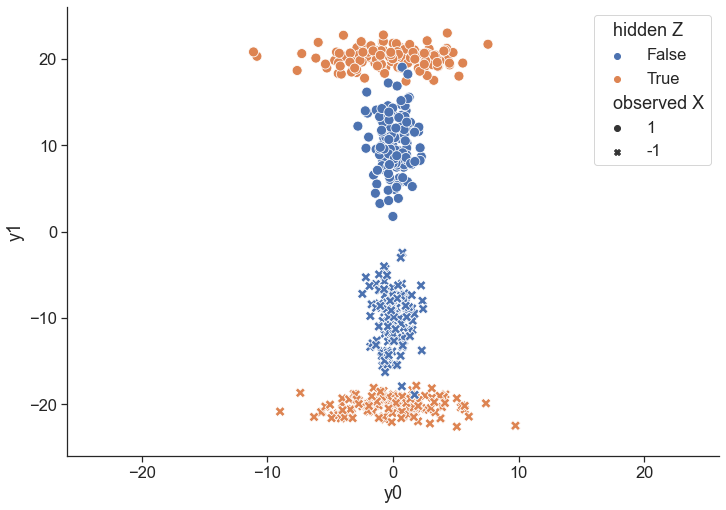

In [5]:
# plot the raw data
sns.scatterplot(data = Y_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)

plt.xlim(-26, 26)
plt.ylim(-26, 26)
sns.despine()

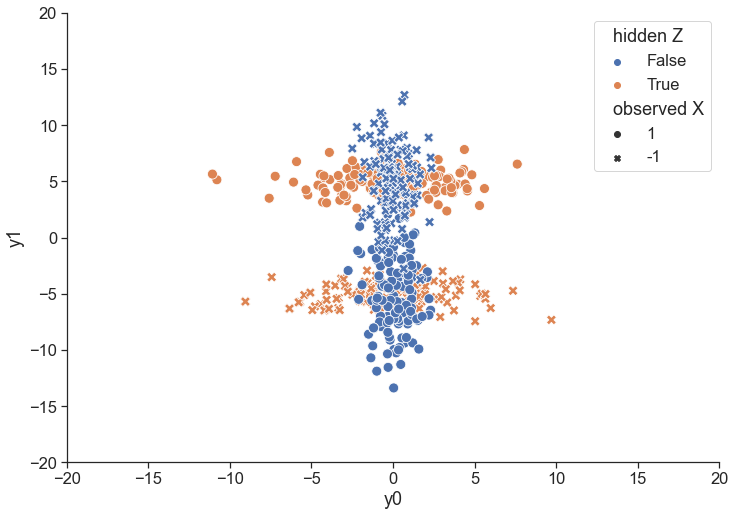

In [6]:
# plot residual data, with the average (homogeneous over Z) effect of X removed
# (requires knowledge of X but not of Z)
sns.scatterplot(data = Y_avgX_empirical_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)

plt.xlim(-20, 20)
plt.ylim(-20, 20)
sns.despine()

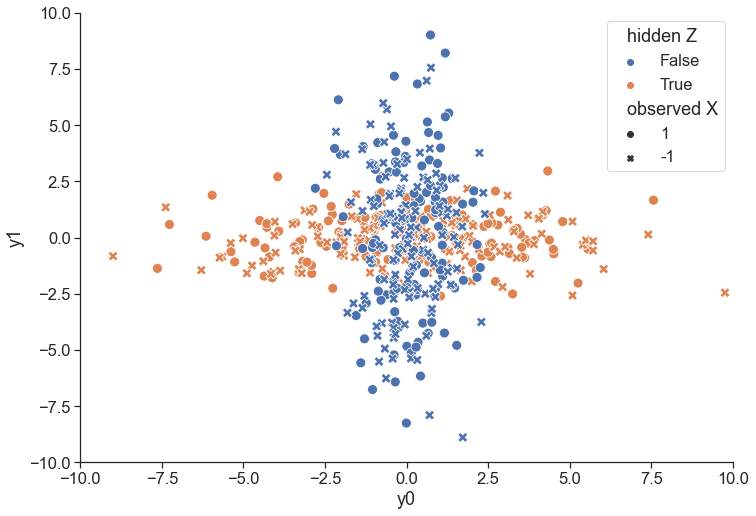

In [7]:
# plot residual data, with the average heterogeneous effect of X removed 
# (requires knowledge of X and of Z)
sns.scatterplot(data = Y_noX_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)

plt.xlim(-10, 10)
plt.ylim(-10, 10)
sns.despine()

# run the EMs

We run three different EM algorithm on this data set, to see if they have the ability to identify the hidden variable

In [8]:
# EM parameters
K=2
# no need for graph penalties in this 2D experiment
l1 = 0
l2 = 0

# stopping criteria (here, we take the same for both the EM and the ADMM/PGD in the M steps)
loss_shift_threshold=1e-5
Lambda_shift_threshold=1e-5
Theta_shift_threshold=1e-5

# do we want the prints?
verbose = True
# number of steps before we start to reduce the temperature more drastically
max_steps=100

In [9]:
# common random init for the EM and Conditional EM (C-EM)
pi_0, mu_0, Sigma_0, Lambda_0, Theta_0= random_2D_parameters(Y, K, q)
# random init unique to the EM with a priori residualised data EMres
pi_0_EMres, mu_0_EMres, Sigma_0_EMres, Lambda_0_EMres, Theta_0_EMres= random_2D_parameters(Y_avgX_empirical, K, q)

## EM

First, a classical EM on the observed data $Y$, without using the co-feature $X$

In [11]:
# run EM
pi_t, mu_t, Lambda_t = EM_GGM(
    # data
    Y, 
    # number of classes desired
    K, 
    # penalty on the precision matrix
    l1, l2, 
    # initial values of the parameters
    pi_0, mu_0, Lambda_0, 
    # stopping criteria of the EM
    loss_shift_threshold_EM=loss_shift_threshold, Lambda_shift_threshold_EM=Lambda_shift_threshold,
    # stopping criteria of the ADMM in the M step
    loss_shift_threshold_ADMM=loss_shift_threshold, Lambda_shift_threshold_ADMM=Lambda_shift_threshold,
    # do we want the prints?
    verbose = verbose, 
    # maximum number of steps
    max_steps=max_steps)

# get Sigma_t
Sigma_t = xr.DataArray(
    data = np.linalg.inv(Lambda_t), 
    coords = [range(K),
              range(p), 
              range(p)], 
    dims = ["label",
            "component_y", 
            "component_yT"] )

negative log likelihood at step 0 = 0.802819325538197
negative log likelihood at step 1 = 0.7749346101258723
negative log likelihood at step 2 = 0.771563606011031
negative log likelihood at step 3 = 0.7673335734194356
negative log likelihood at step 4 = 0.7644564420468389
negative log likelihood at step 5 = 0.7639320446523463
negative log likelihood at step 6 = 0.7639112822033035
negative log likelihood at step 7 = 0.7639108332651915
negative log likelihood at step 8 = 0.7639108241274648
negative log likelihood at step 9 = 0.7639108239422474


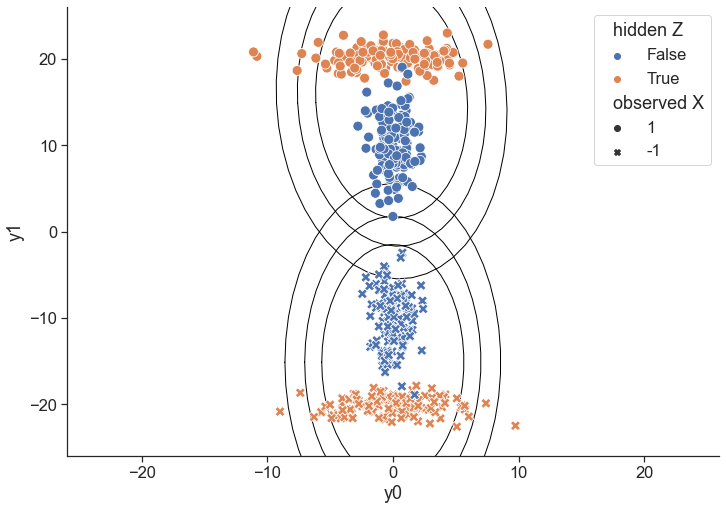

In [12]:
# add estimated ellipses
# plot the data
sns.scatterplot(data = Y_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)
plot_ellipse(mu_t, Sigma_t, unique_color="black")
plot_ellipse(mu_t, Sigma_t, confidence_level=0.99,  unique_color="black")
plot_ellipse(mu_t, Sigma_t, confidence_level=0.999,  unique_color="black")
plt.xlim(-26, 26)
plt.ylim(-26, 26)
sns.despine()

## EMres

Then, still a classical EM, but the residualised data $Y-\hat{\beta}^T X$ this time. Where $\hat{\beta}$ is the Ordinary Least Square estimator of the linear regression between $X$ and $Y$. This linear regression is homogeneous, run without knowledge of $Z$.

In [13]:
# run EM on the residualised data where the average effect of X was subtracted a priori
pi_t, mu_t, Lambda_t = EM_GGM(
    # data
    Y_avgX_empirical, 
    # number of classes desired
    K, 
    # penalty on the precision matrix
    l1, l2, 
    # initial values of the parameters
    pi_0_EMres, mu_0_EMres, Lambda_0_EMres,
    # stopping criteria of the EM
    loss_shift_threshold_EM=loss_shift_threshold, Lambda_shift_threshold_EM=Lambda_shift_threshold,
    # stopping criteria of the ADMM in the M step
    loss_shift_threshold_ADMM=loss_shift_threshold, Lambda_shift_threshold_ADMM=Lambda_shift_threshold,
    # do we want the prints?
    verbose = verbose, 
    # maximum number of steps
    max_steps=max_steps)

# get Sigma_t
Sigma_t = xr.DataArray(
    data = np.linalg.inv(Lambda_t), 
    coords = [range(K),
              range(p), 
              range(p)], 
    dims = ["label",
            "component_y", 
            "component_yT"] )

negative log likelihood at step 0 = 0.7262641786744061
negative log likelihood at step 1 = 0.6765703792235505
negative log likelihood at step 2 = 0.6757014226706187
negative log likelihood at step 3 = 0.6749870876779576
negative log likelihood at step 4 = 0.6747313151665744
negative log likelihood at step 5 = 0.6745938085860207
negative log likelihood at step 6 = 0.6744929032397721
negative log likelihood at step 7 = 0.6743920851802481
negative log likelihood at step 8 = 0.6742693664824768
negative log likelihood at step 9 = 0.6741051635483502
negative log likelihood at step 10 = 0.6738794299241968
negative log likelihood at step 11 = 0.6735717897925344
negative log likelihood at step 12 = 0.6731608615899922
negative log likelihood at step 13 = 0.672620062079541
negative log likelihood at step 14 = 0.6719109662569892
negative log likelihood at step 15 = 0.6709863494685772
negative log likelihood at step 16 = 0.6698222961456625
negative log likelihood at step 17 = 0.668453141445823
nega

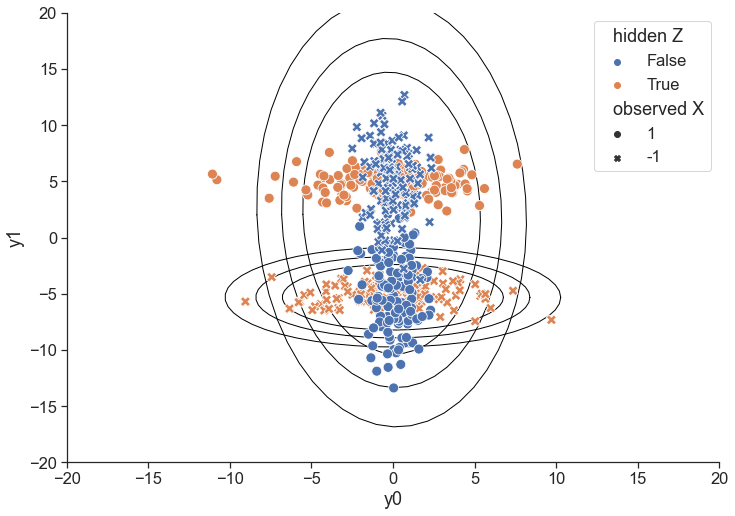

In [14]:
# plot residual data, with the average (homogeneous over Z) effect of X removed
# (requires knowledge of X but not of Z)
sns.scatterplot(data = Y_avgX_empirical_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)
# add estimated ellipses
plot_ellipse(mu_t, Sigma_t, unique_color="black")
plot_ellipse(mu_t, Sigma_t, confidence_level=0.99,  unique_color="black")
plot_ellipse(mu_t, Sigma_t, confidence_level=0.999,  unique_color="black")
sns.despine()
plt.xlim(-20, 20)
plt.ylim(-20, 20)
sns.despine()

## C-EM

Finally, an EM that estimates a Conditional Mixture of Gaussian (or "conditional EM", "C-EM"). Which can identify heterogeneous effects of $X$ on $Y$: $\mathbb{E}[Y | X, Z= k, \hat{\beta}] = \hat{\beta}_k^T X$. Where the $(\hat{\beta}_k)_{k=1}^K$ are estimated along the class labels, within the EM procedure.

In [15]:
# run EM
pi_t, Lambda_t, Sigma_t, Theta_t = EM(
    # data
    Y, X_da, 
    # number of classes desired
    K, 
    # penalty on the precision matrix
    l1, l2,
    # penalty on the transition matrix
    l1, l2,
    # initial values of the parameters
    pi_0, Lambda_0, Sigma_0, Theta_0, 
     # stopping criteria of the EM
    loss_shift_threshold, Lambda_shift_threshold, Theta_shift_threshold,
    # stopping criteria of the proximal gradient descent in the M step
    loss_shift_threshold, Lambda_shift_threshold, Theta_shift_threshold,        
    # do we want the prints?
    verbose=verbose,
    # maximum number of steps
    max_steps=max_steps)

negative log likelihood at step 0 = 0.6847059062090164
negative log likelihood at step 1 = 0.4464551197644125
negative log likelihood at step 2 = 0.44320373905796645
negative log likelihood at step 3 = 0.4394135999876135
negative log likelihood at step 4 = 0.43612195122594233
negative log likelihood at step 5 = 0.433892259761246
negative log likelihood at step 6 = 0.43261833163299596
negative log likelihood at step 7 = 0.4317025351790932
negative log likelihood at step 8 = 0.43064848628483166
negative log likelihood at step 9 = 0.42905973814092496
negative log likelihood at step 10 = 0.42623371186718323
negative log likelihood at step 11 = 0.42041453417125363
negative log likelihood at step 12 = 0.4083609501758714
negative log likelihood at step 13 = 0.38755229506376043
negative log likelihood at step 14 = 0.3672503410612288
negative log likelihood at step 15 = 0.358345433925131
negative log likelihood at step 16 = 0.35572246235949195
negative log likelihood at step 17 = 0.355380422148

To display these results, we can:
1) Look how the estimated covariance matrices fit the heterogeneously residualised data

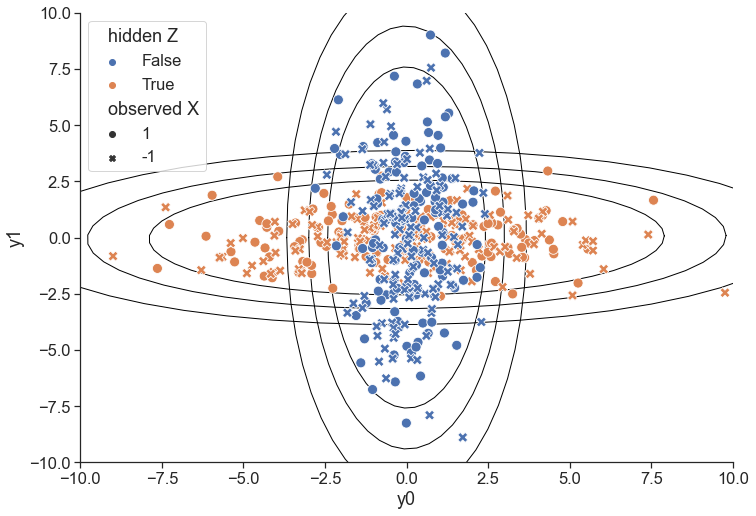

In [16]:
# plot residual data, with the average heterogeneous effect of X removed 
sns.scatterplot(data = Y_noX_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)

# add estimated ellipses
plot_ellipse(mu_t*0, Sigma_t, unique_color="black")
plot_ellipse(mu_t*0, Sigma_t, confidence_level=0.99,  unique_color="black")
plot_ellipse(mu_t*0, Sigma_t, confidence_level=0.999,  unique_color="black")

plt.xlim(-10, 10)
plt.ylim(-10, 10)
sns.despine()

2) Compute the estimated $\mathbb{E}[Y|X, \hat{\beta}]$ (which are effectively cluster averages in this example)\
They define four effective clusters each centred on one of the following:
- $\mathbb{E}[Y|X=-1, Z=+1, \hat{\beta}]$
- $\mathbb{E}[Y|X=+1, Z=+1, \hat{\beta}]$
- $\mathbb{E}[Y|X=-1, Z=-1, \hat{\beta}]$
- $\mathbb{E}[Y|X=+1, Z=-1, \hat{\beta}]$

In [17]:
# Estimated E[Y|X=-1]
mu_t_0 = xr.dot(Sigma_t,  xr.dot(Theta_t, X_da, dims="component_x"), 
                dims = "component_y").sel(observation_id=0).rename({"component_yT":"component_y"})
# ("observation_id=0" in this example verifies X=-1)

# Estimated E[Y|X=1]
mu_t_1 = xr.dot(Sigma_t,  xr.dot(Theta_t, X_da, dims="component_x"),
                dims = "component_y").sel(observation_id=n_total-1).rename({"component_yT":"component_y"})
# ("observation_id=n-1" in this example verifies X=+1)

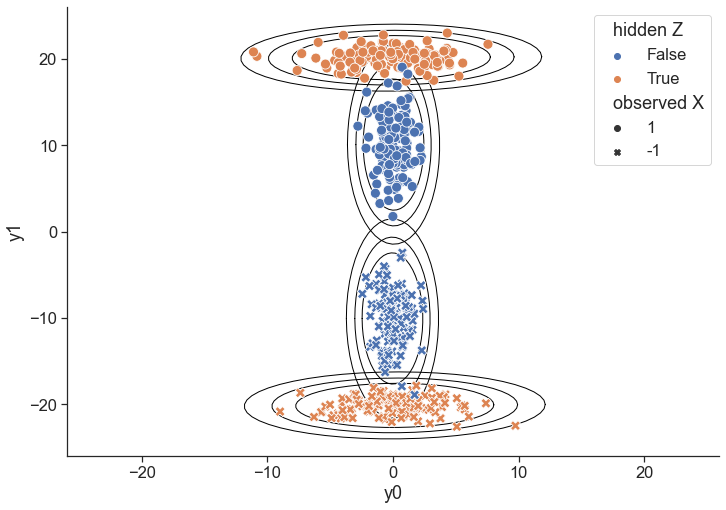

In [18]:
# Display
sns.scatterplot(data = Y_df, x='y0', y='y1', 
                hue = 'hidden Z', 
                style = 'observed X', style_order = [1, -1],
                s=100)


# add estimated ellipses
plot_ellipse(mu_t_0, Sigma_t, unique_color="black")
plot_ellipse(mu_t_0, Sigma_t, unique_color="black",confidence_level=0.99)
plot_ellipse(mu_t_0, Sigma_t, unique_color="black",confidence_level=0.999)
# add estimated ellipses
plot_ellipse(mu_t_1, Sigma_t, unique_color="black")
plot_ellipse(mu_t_1, Sigma_t, unique_color="black",confidence_level=0.99)
plot_ellipse(mu_t_1, Sigma_t, unique_color="black",confidence_level=0.999)
plt.xlim(-26, 26)
plt.ylim(-26, 26)
sns.despine()